In [4]:
import mne
import matplotlib.pyplot as plt
from nilearn.masking import apply_mask, compute_epi_mask
import numpy as np

path_eeg = '/home/davidcalhas/eeg_to_fmri/datasets/'

dataset = '02/ds116/'

individual = 'sub-01/'

fmri_file = 'func/sub-01_task-auditoryoddballwithbuttonresponsetotargetstimuli_run-01_bold.nii.gz'

complete_path = path_eeg + dataset + individual + fmri_file

In [5]:
complete_path

'/home/davidcalhas/eeg_to_fmri/datasets/02/ds116/sub-01/func/sub-01_task-auditoryoddballwithbuttonresponsetotargetstimuli_run-01_bold.nii.gz'

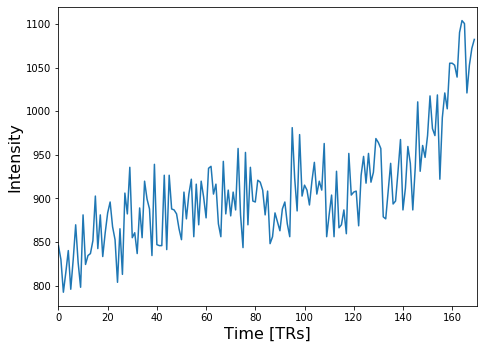

In [7]:
mask_img = compute_epi_mask(complete_path)

masked_data = apply_mask(complete_path, mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 150
# timepoints from two voxels



# And now plot a few of these
plt.figure(figsize=(7, 5))
plt.plot(masked_data[:, 5:6])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, masked_data.shape[0])
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

In [10]:
import numpy as np

from nilearn import _utils

import nilearn.image as image
from nilearn.decomposition import CanICA
from nilearn.input_data import NiftiMasker

from nilearn.image import new_img_like

from nilearn.masking import _apply_mask_fmri

from nilearn.plotting import plot_stat_map

#when its a population of n individuals
#imgs=[complete_path_ind_1, complete_path_ind_2, ..., complete_path_ind_n]
def _apply_mask(imgs, mask_img):
    mask_img = _utils.check_niimg_3d(mask_img)
    
    mask_img = _utils.check_niimg_3d(mask_img)
    mask = mask_img.get_data()
    mask = _utils.as_ndarray(mask, dtype=bool)
    
    mask_img = new_img_like(mask_img, mask, mask_img.affine)
    
    return _apply_mask_fmri(imgs, mask_img, dtype='f', smoothing_fwhm=None, ensure_finite=True)


class roi_time_series:
    def __init__(self, canica=None):
        self.canica = None
        
    def _set_ICA(self, imgs, n_components=20, verbose=0):
        self.canica = CanICA(n_components=n_components, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=verbose, random_state=0)
        self._fit_ICA(imgs)
        
    def _fit_ICA(self, imgs):
        self.canica.fit(imgs)
        
    def get_ROI_time_series(self, imgs, component=0, n_components=20, verbose=False):

        #smooth image
        fmri_original = image.load_img(imgs)
        fmri_img = image.smooth_img(fmri_original, fwhm=6)

        #perform ICA and get components
        if(self.canica == None):
            if(verbose):
                print("New ICA computation")
            self._set_ICA(fmri_img, n_components=n_components)

        components_img = self.canica.components_img_

        #build masker
        roi_masker = NiftiMasker(mask_img=image.index_img(components_img, component),
                            standardize=True,
                            memory="nilearn_cache",
                            smoothing_fwhm=8)

        return _apply_mask(imgs, roi_masker.mask_img)
    
roi_extraction = roi_time_series()

In [11]:
roi_extraction.get_ROI_time_series(complete_path, component=0, n_components=30).shape

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/nilearn/input_data/nifti_masker.py:308: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  dtype=self.dtype
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  Converg

(170, 3248)